## Detecção de Anomalias em Sinais com Autoencoders

**Objetivo:** Utilizar uma rede neural do tipo Autoencoder para aprender o padrão de vibração de um motor em estado saudável e, a partir disso, detectar anomalias que podem ser precursoras de falhas.

**Contexto:** Enquanto técnicas como FFT e Wavelets são excelentes para analisar frequências e encontrar falhas com assinaturas conhecidas, os Autoencoders brilham em um cenário diferente. Eles são usados em uma abordagem de aprendizado **semi-supervisionado** (ou não supervisionado), onde a principal vantagem é:

> **Precisamos apenas de dados da máquina operando normalmente para treinar o modelo.**

**Como Funciona?**
1.  Um **Autoencoder** é uma rede neural com uma arquitetura simétrica em forma de ampulheta (Encoder -> Bottleneck -> Decoder).
2.  O **Encoder** aprende a comprimir o sinal de entrada em uma representação de baixa dimensão (o *bottleneck*).
3.  O **Decoder** aprende a reconstruir o sinal original a partir dessa representação comprimida.
4.  Quando treinado **apenas com dados normais**, o autoencoder se torna um especialista em reconstruir sinais saudáveis, resultando em um baixo **erro de reconstrução**.
5.  Quando um sinal **anômalo** (de uma falha) é apresentado ao modelo, ele falha em reconstruí-lo bem, gerando um **erro de reconstrução alto**. Este erro elevado é o nosso sinal de anomalia.

### Configuração e Importação de Bibliotecas

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Configurações de visualização
plt.rcParams["figure.figsize"] = (16, 5)

### Geração e Pré-processamento dos Dados

Vamos gerar três tipos de sinais:
1.  **Sinal Saudável (Longo):** Para treinar e validar o modelo.
2.  **Sinal Anômalo 1 (Desgaste):** A mesma frequência, mas com maior amplitude e ruído.
3.  **Sinal Anômalo 2 (Desalinhamento):** Adição de uma nova componente de frequência (2x a frequência de rotação).

Depois, vamos fatiar esses sinais em pequenas **janelas** de tamanho fixo, que servirão de entrada para a nossa rede neural.

In [9]:
# Parâmetros da Simulação
SAMPLING_RATE = 500
F_MOTOR = 60  # Hz
t_train = np.linspace(0, 100, 100 * SAMPLING_RATE, endpoint=False)
t_test = np.linspace(0, 10, 10 * SAMPLING_RATE, endpoint=False)

# 1. Sinal Saudável
signal_healthy = (
    1.0 * np.sin(2 * np.pi * F_MOTOR * t_train) + np.random.randn(len(t_train)) * 0.1
)

# 2. Sinais Anômalos para Teste
signal_anomaly_wear = (
    1.5 * np.sin(2 * np.pi * F_MOTOR * t_test) + np.random.randn(len(t_test)) * 0.3
)  # Maior amplitude e ruído
signal_anomaly_misaligned = (
    1.0 * np.sin(2 * np.pi * F_MOTOR * t_test)
    + 0.8 * np.sin(2 * np.pi * 2 * F_MOTOR * t_test)
    + np.random.randn(len(t_test)) * 0.1
)  # Frequência 2x


# Função para criar janelas a partir do sinal
def create_windows(signal, window_size):
    windows = []
    for i in range(len(signal) - window_size + 1):
        windows.append(signal[i : i + window_size])
    return np.array(windows)


WINDOW_SIZE = 250  # Tamanho de cada segmento de sinal

# Criando o dataset de treino (APENAS DADOS SAUDÁVEIS)
X_train = create_windows(signal_healthy, WINDOW_SIZE)

# Criando o dataset de teste (mistura de saudável e anômalo)
healthy_test_windows = create_windows(
    signal_healthy[: len(t_test)], WINDOW_SIZE
)  # Pega um pedaço do saudável para teste
anomaly_wear_windows = create_windows(signal_anomaly_wear, WINDOW_SIZE)
anomaly_misaligned_windows = create_windows(signal_anomaly_misaligned, WINDOW_SIZE)

X_test = np.concatenate(
    [healthy_test_windows, anomaly_wear_windows, anomaly_misaligned_windows]
)

# Criando labels para o teste (0=Saudável, 1=Anomalia)
y_test = np.concatenate(
    [
        np.zeros(len(healthy_test_windows)),
        np.ones(len(anomaly_wear_windows)),
        np.ones(len(anomaly_misaligned_windows)),
    ]
)

# Normalização dos dados (essencial para redes neurais)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Janelas de treino: {X_train_scaled.shape}")
print(f"Janelas de teste: {X_test_scaled.shape}")

Janelas de treino: (49751, 250)
Janelas de teste: (14253, 250)


### Construção do Modelo Autoencoder

Vamos construir uma arquitetura simples de Autoencoder com camadas densas (fully-connected).

In [10]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 32  # Tamanho do bottleneck (hiperparâmetro)

# Camada de Entrada
input_layer = Input(shape=(input_dim,))

# Encoder
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)
encoder = Dense(encoding_dim, activation="relu")(encoder)

# Decoder
decoder = Dense(64, activation="relu")(encoder)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(input_dim, activation="tanh")(
    decoder
)  # 'tanh' porque normalizamos para [-1, 1]

# Modelo Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compilação do modelo
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 250)            │        32,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,146 (332.60 KB)

 Trainable params: 85,146 (332.60 KB)

 Non-trainable params: 0 (0.00 B)

### Treinamento do Autoencoder

O ponto-chave aqui é que usamos `X_train_scaled` tanto como dado de entrada (`x`) quanto como dado de saída (`y`). O modelo está aprendendo a reconstruir a si mesmo.

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0301 - val_loss: 0.0060
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 10/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 11/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 12/100
175/175 ━━━━━━━━━━━━━━━━━━━━

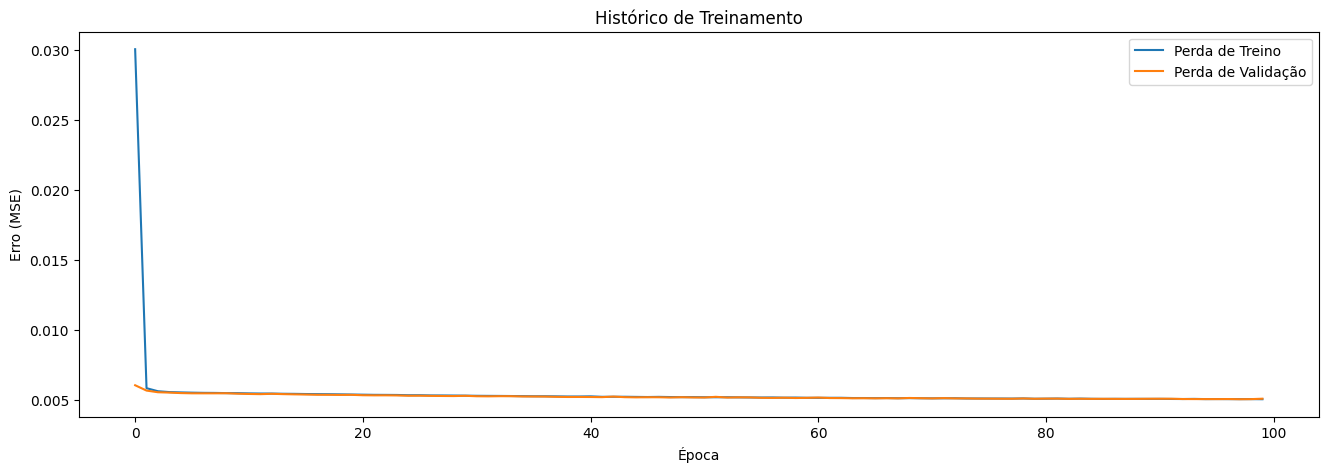

In [11]:
history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,  # Entrada e saída são as mesmas
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
)

# Plotando a perda de treino e validação
plt.plot(history.history["loss"], label="Perda de Treino")
plt.plot(history.history["val_loss"], label="Perda de Validação")
plt.title("Histórico de Treinamento")
plt.xlabel("Época")
plt.ylabel("Erro (MSE)")
plt.legend()

### Detecção de Anomalias com Base no Erro de Reconstrução

Agora vem a parte crucial. Vamos usar o modelo treinado para reconstruir os dados de teste (que contêm sinais saudáveis e anômalos) e calcular o erro de reconstrução para cada janela.

446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Limiar de anomalia calculado: 0.0066


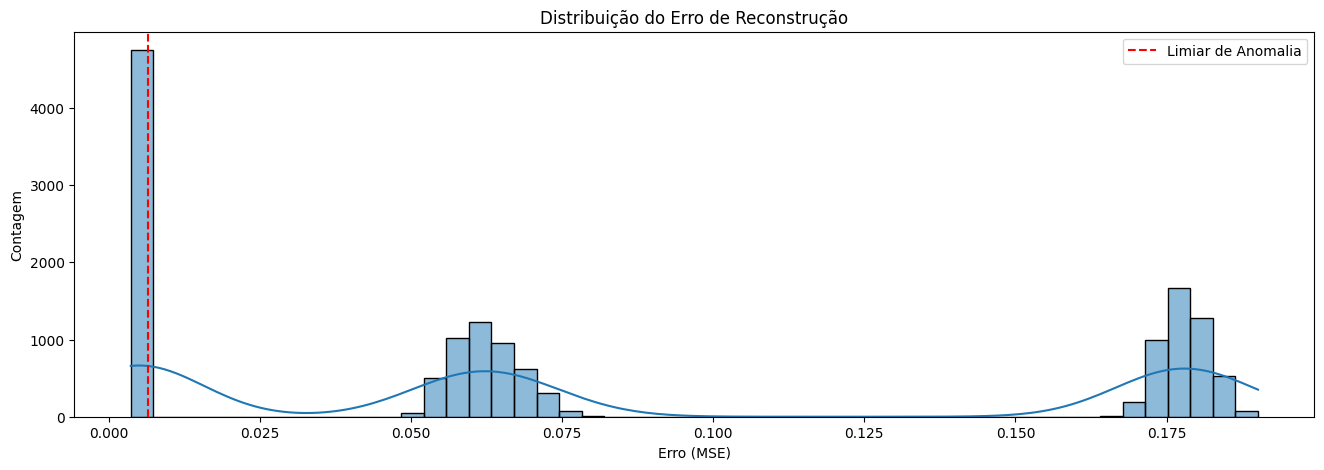

In [12]:
# 1. Reconstruir os dados de teste
reconstructions = autoencoder.predict(X_test_scaled)

# 2. Calcular o erro de reconstrução (MSE) para cada janela
reconstruction_errors = tf.keras.losses.mse(X_test_scaled, reconstructions)

# 3. Determinar um limiar (threshold) de anomalia
# Para isso, vamos ver o erro de reconstrução APENAS para os dados saudáveis do nosso split
healthy_errors = reconstruction_errors[y_test == 0]
threshold = np.mean(healthy_errors) + 3 * np.std(healthy_errors)

print(f"Limiar de anomalia calculado: {threshold:.4f}")

# 4. Visualizar a distribuição dos erros
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.axvline(threshold, color="r", linestyle="--", label="Limiar de Anomalia")
plt.title("Distribuição do Erro de Reconstrução")
plt.xlabel("Erro (MSE)")
plt.ylabel("Contagem")
plt.legend()

**Análise do Gráfico:** O histograma deve mostrar duas distribuições. Uma concentrada à esquerda com erros baixos (dados saudáveis) e outra mais à direita com erros altos (dados anômalos). Nosso limiar deve separar bem essas duas populações.

Resultados da Detecção de Anomalia:
   Reconstruction_Error  True_Class  Predicted_Class
0              0.004908         0.0            False
1              0.004788         0.0            False
2              0.004876         0.0            False
3              0.005132         0.0            False
4              0.005159         0.0            False


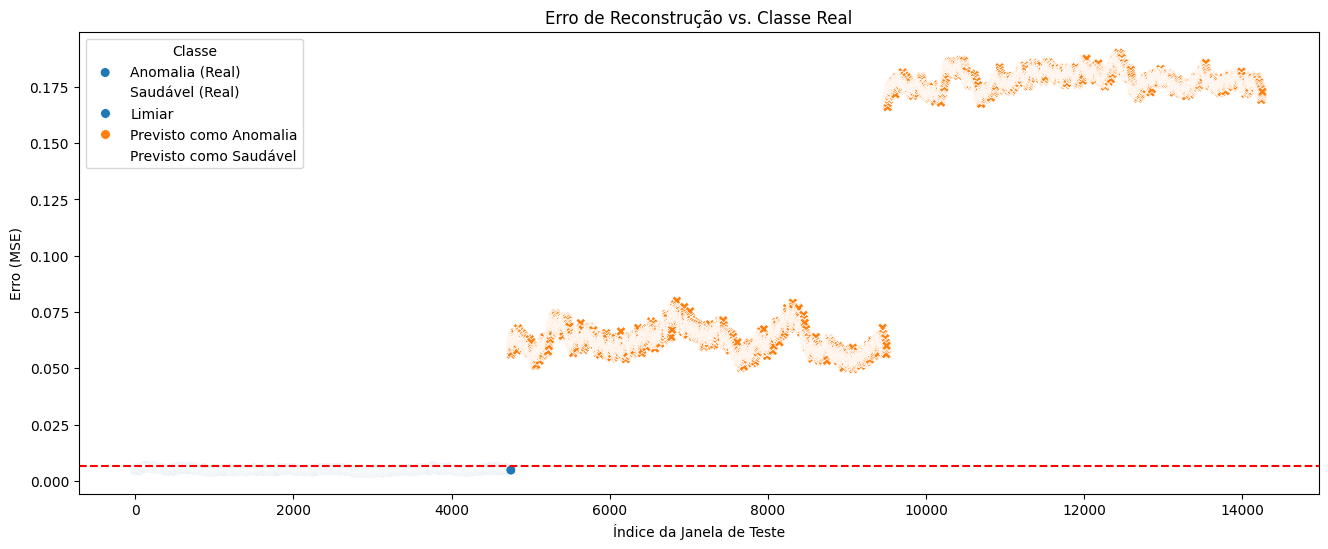

In [13]:
# Classificar anomalias
predictions = (reconstruction_errors > threshold).numpy()

results_df = pd.DataFrame(
    {
        "Reconstruction_Error": reconstruction_errors,
        "True_Class": y_test,
        "Predicted_Class": predictions,
    }
)

print("Resultados da Detecção de Anomalia:")
print(results_df.head())

plt.figure(figsize=(16, 6))
sns.scatterplot(
    x=results_df.index,
    y="Reconstruction_Error",
    hue="True_Class",
    data=results_df,
    style="Predicted_Class",
    s=50,
)
plt.axhline(threshold, color="r", linestyle="--", label="Limiar")
plt.title("Erro de Reconstrução vs. Classe Real")
plt.xlabel("Índice da Janela de Teste")
plt.ylabel("Erro (MSE)")
plt.legend(
    title="Classe",
    labels=[
        "Anomalia (Real)",
        "Saudável (Real)",
        "Limiar",
        "Previsto como Anomalia",
        "Previsto como Saudável",
    ],
)

### Visualizando a Reconstrução

Para entender *por que* o erro é diferente, vamos plotar um exemplo de sinal saudável e um anômalo lado a lado com suas reconstruções.

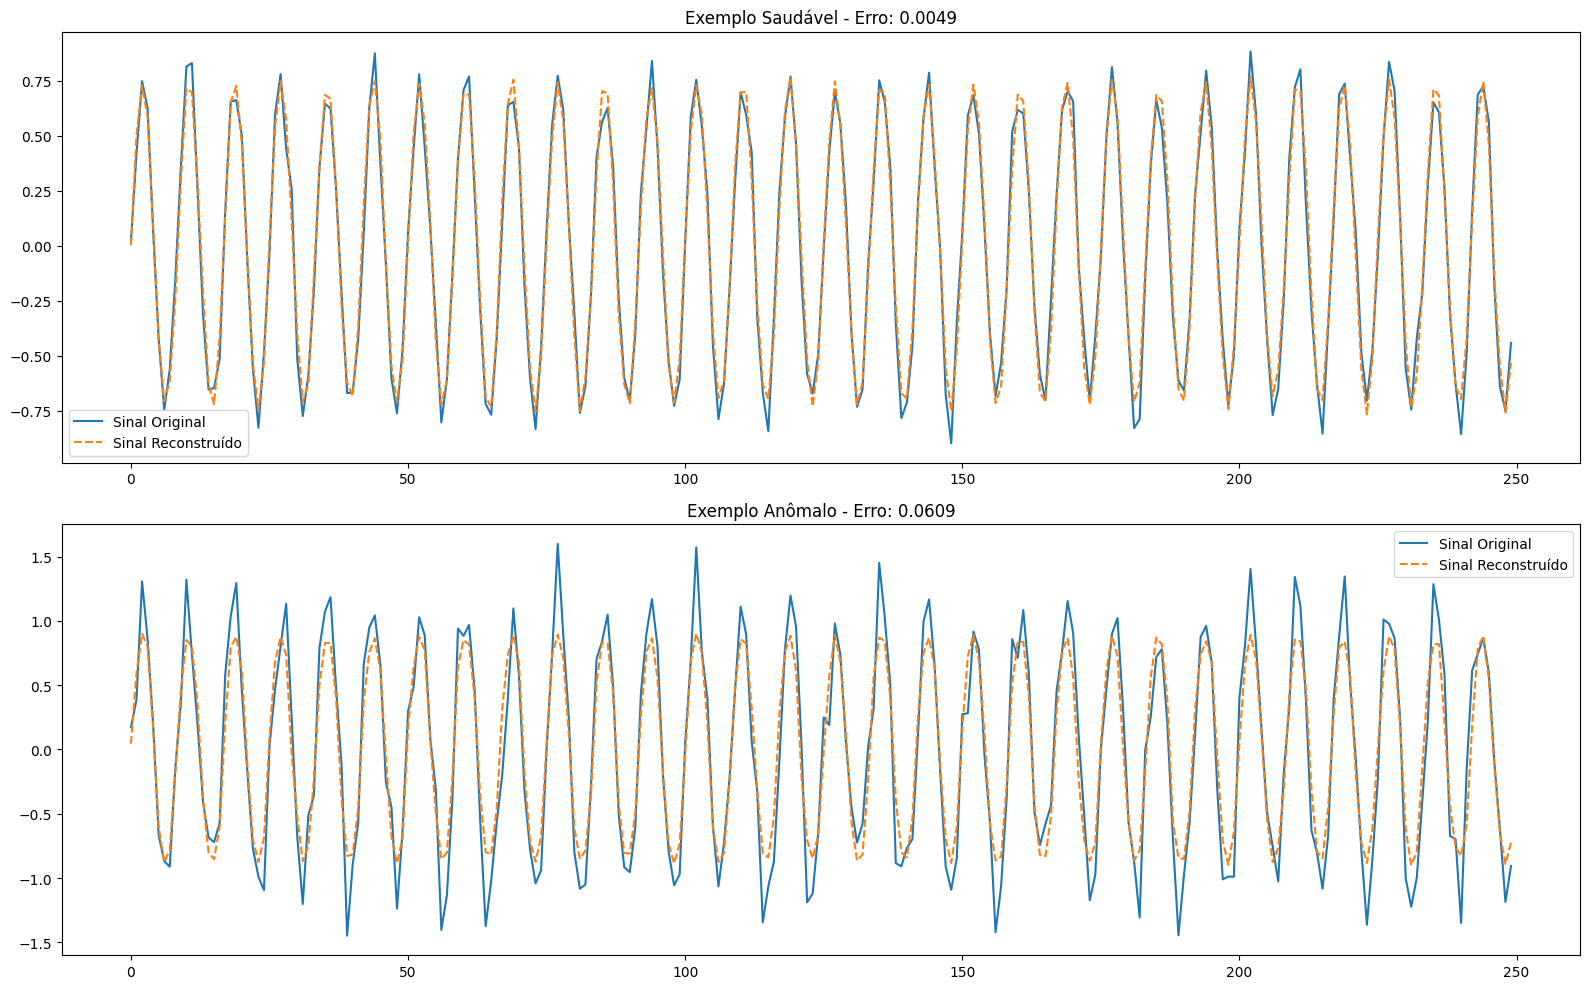

In [14]:
# Encontra um índice para um exemplo saudável e um anômalo
idx_healthy = np.where(y_test == 0)[0][0]
idx_anomaly = np.where(y_test == 1)[0][0]

fig, axs = plt.subplots(2, 1, figsize=(16, 10))

# Exemplo Saudável
axs[0].plot(X_test_scaled[idx_healthy], label="Sinal Original")
axs[0].plot(reconstructions[idx_healthy], label="Sinal Reconstruído", linestyle="--")
axs[0].set_title(f"Exemplo Saudável - Erro: {reconstruction_errors[idx_healthy]:.4f}")
axs[0].legend()

# Exemplo Anômalo
axs[1].plot(X_test_scaled[idx_anomaly], label="Sinal Original")
axs[1].plot(reconstructions[idx_anomaly], label="Sinal Reconstruído", linestyle="--")
axs[1].set_title(f"Exemplo Anômalo - Erro: {reconstruction_errors[idx_anomaly]:.4f}")
axs[1].legend()

plt.tight_layout()

**Análise Final:** Fica claro que o autoencoder reconstrói o sinal saudável quase perfeitamente (linhas sobrepostas), resultando em baixo erro. Já para o sinal anômalo, a reconstrução é visivelmente pobre, pois o modelo tenta forçar o padrão desconhecido a se parecer com o padrão saudável que ele aprendeu, resultando em um erro de reconstrução alto.

### Conclusão

O Autoencoder provou ser uma ferramenta extremamente eficaz para a detecção de anomalias em sinais de vibração.

1.  **Aprendizado Não Supervisionado:** A maior vantagem é a capacidade de treinar um modelo robusto usando apenas dados de operação normal, que são muito mais fáceis de coletar em ambientes industriais do que dados rotulados para cada tipo de falha possível.

2.  **Generalização:** O modelo não está limitado a detectar falhas específicas que ele já viu. Ele é capaz de sinalizar qualquer desvio significativo do comportamento normal, permitindo a detecção de **falhas novas e inesperadas**.

3.  **Implementação:** Um modelo como este pode ser implantado em um sistema de monitoramento contínuo. Novos dados de vibração são coletados, fatiados em janelas, e passados pelo autoencoder treinado. Se o erro de reconstrução exceder o limiar pré-definido por um período de tempo, um alerta é enviado para a equipe de manutenção para uma inspeção mais detalhada, possibilitando a manutenção antes que uma falha catastrófica ocorra.